In [1]:
import numpy as np
import matplotlib.pyplot as plt

from dataclasses import dataclass
from fractions import Fraction
from hybrid_ode_sim.simulation.simulator import Simulator, ModelGraph
from hybrid_ode_sim.simulation.utils import ContinuousTimeModel, DiscreteTimeModel
from hybrid_ode_sim.simulation.ode_solvers.fixed_step_solver import RK4
from hybrid_ode_sim.simulation.ode_solvers.adaptive_step_solver import RK23

# PID Controller for Spring-Mass-Damper

In [5]:
@dataclass
class SpringParams:
    k: float
    m: float
    b: float

@dataclass
class PIDControllerParams:
    kP: float
    kD: float
    kI: float
    
    
class Spring(ContinuousTimeModel):
    def __init__(self, y0, params: SpringParams):
        super().__init__(y0, name="spring_mass_damper", params=params)
    
    def continuous_dynamics(self, t, y) -> np.ndarray:
        inputs = self.collect_inputs()
        r, v = y
        
        f_applied = inputs['pd_controller']
        return np.array([v, (f_applied - self.params.b*v - self.params.k*r)/self.params.m])


class PIDController(DiscreteTimeModel):
    def __init__(self, y0, sample_rate, params: PIDControllerParams):
        super().__init__(y0, sample_rate, name="pd_controller", params=params)
        self.setpoint = None
        self.integrator = 0
    
    def discrete_dynamics(self, t, y) -> float:
        inputs = self.collect_inputs()
        
        r_ref = inputs['reference']
        r_meas, v_meas = inputs['spring_mass_damper']
        
        if self.setpoint is None or self.setpoint != r_ref:
            self.integrator = 0
        
        self.integrator += (r_ref - r_meas)
        self.setpoint = r_ref
        
        return self.params.kP * (r_ref - r_meas) + (1/self.sample_rate) * self.params.kI * self.integrator + self.params.kD * (0 - v_meas)
        

class ReferenceTrajectory(DiscreteTimeModel):
    def __init__(self, y0, sample_rate):
        super().__init__(y0, sample_rate, name="reference")
    
    def discrete_dynamics(self, t, y) -> float:
        if 0 <= t <= 10:
            return 1
        elif 10 < t <= 20:
            return 0
        else:
            return 1

In [6]:
spring = Spring(y0=np.array([0.0, 0.0]), params=SpringParams(k=100, m=1, b=5))
pd_controller = PIDController(y0=0, sample_rate=50, params=PIDControllerParams(kP=300, kD=40, kI=100))
reference = ReferenceTrajectory(y0=1, sample_rate=5)

reference.inputs_to(pd_controller)
pd_controller.inputs_to(spring)
pd_controller.feedback_from(spring)

model_graph = ModelGraph(models=[spring, pd_controller, reference])

simulator = Simulator(model_graph, RK23(atol=1e-6, rtol=1e-3))
simulator.simulate(t_range=[0, 30])

[Simulator] INFO: Simulation Complete! Elapsed Time: 0.10 s (309.72x real-time)


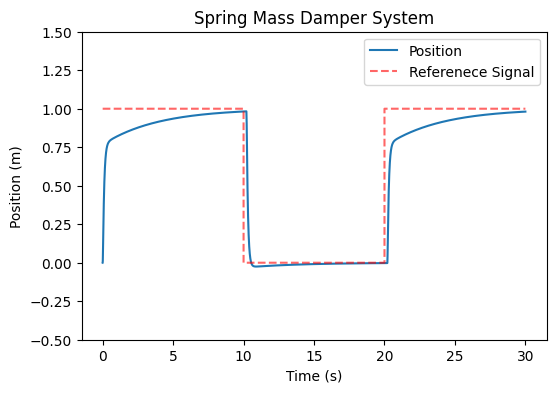

In [7]:
t, y, _ = spring.history()

fig = plt.figure(figsize=(6,4))
plt.plot(t, y[:, 0], label='Position')
plt.plot([0, 10-1e-5, 10, 20-1e-5, 20, 30-1e-5], [1, 1, 0, 0, 1, 1], label='Referenece Signal', color="red", alpha=0.6, linestyle='--')
plt.ylim(-0.5, 1.5)

plt.legend()
plt.title("Spring Mass Damper System")
plt.xlabel("Time (s)")
plt.ylabel("Position (m)")
plt.show()

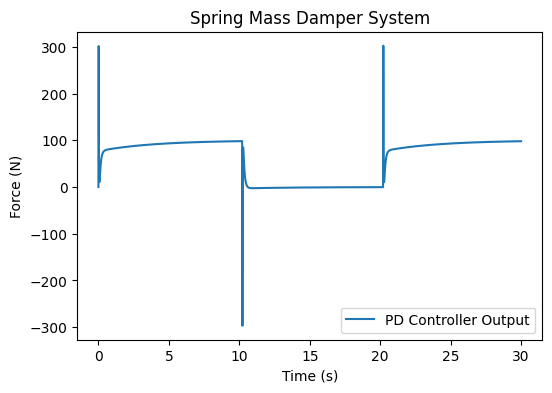

In [8]:
t, y, _ = pd_controller.history()

fig = plt.figure(figsize=(6,4))
plt.plot(t, y, label='PD Controller Output')

plt.legend()
plt.title("Spring Mass Damper System")
plt.xlabel("Time (s)")
plt.ylabel("Force (N)")
plt.show()